<a href="https://colab.research.google.com/github/NaraineSurya/Human-Segmentation-Using-Pytorch/blob/master/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.5 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=4b6c1ce1fe9b523be7ea7dff15d10a9f32aaed0e67af279b5b88b2f4085c5e55
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=3428fc88da222adf1ab6d4ac44e361ef9d0dafb08232aaebf8587a7b9fea1d4a
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f53

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [2]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 31.51 MiB/s, done.
Resolving deltas: 100% (3/3), done.


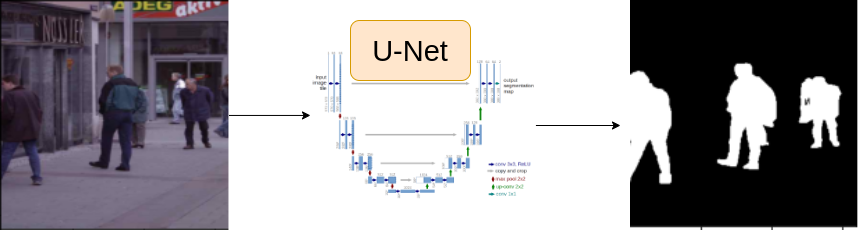

# Some Common Imports

In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [5]:
CSV_File = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content/'

DEVICE = 'cuda'

EPOCHS = 25
Learning_rate = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'time-efficientnet-b0'
WEIGTHS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_File)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [7]:
row = df.iloc[4]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path,cv2.IMREAD_GRAYSCALE) / 255.0

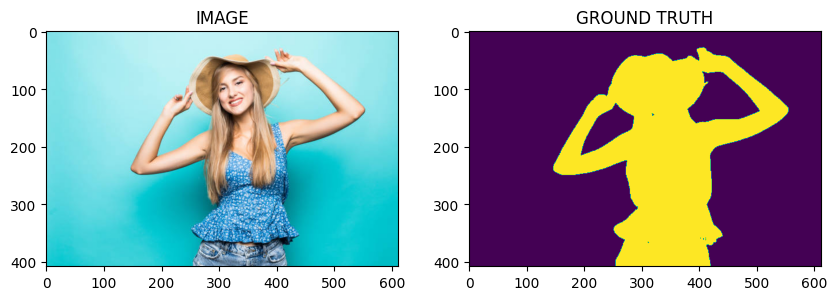

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
#ax2.imshow(mask,cmap = 'gray')
ax2.imshow(mask)

In [9]:
train_df,valid_df = train_test_split(df,test_size = 0.2, random_state = 42)

# valid_images = valid_df['images']
# valid_masks = valid_df['masks']

# print("Training set:")
# print("Images:", valid_images[:5])
# print("Masks:", valid_masks[:5])

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [10]:
import albumentations as A

In [11]:
def get_train_args():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),           #height,width
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5),
  ],is_check_shapes=False)

def get_valid_args():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
  ],is_check_shapes=False)

# Task 4 : Create Custom Dataset

In [12]:
from torch.utils.data import Dataset

In [13]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask, is_check_shapes=False)
      image = data['image']
      mask = data['mask']

    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask


In [14]:
trainset  = SegmentationDataset(train_df, get_train_args())
validset = SegmentationDataset(valid_df, get_valid_args())

In [15]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


torch.Size([3, 320, 320])
torch.Size([1, 320, 320])


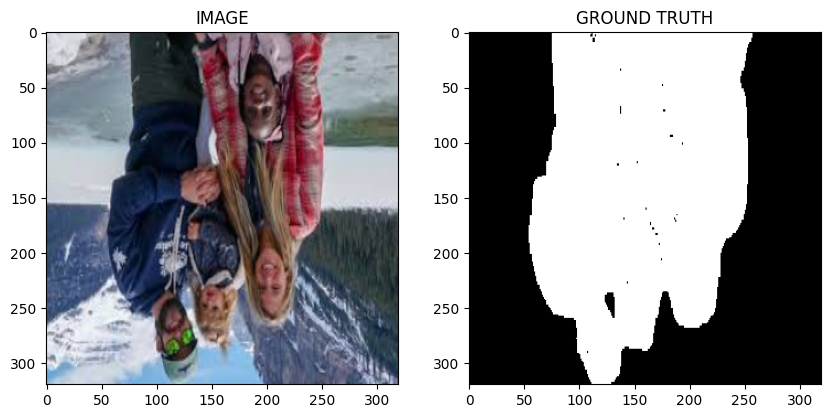

In [16]:
 idx = 2

image, mask = trainset[idx]
print(image.shape)
print(mask.shape)
helper.show_image(image,mask)


# Task 5 : Load dataset into batches

In [17]:
from torch.utils.data import DataLoader

In [18]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [19]:
print(f"Total no of batch in training set {len(trainloader)}")
print(f"Total no of batch in valid set {len(validloader)}")

Total no of batch in training set 15
Total no of batch in valid set 4


In [20]:
for image,mask in trainloader:
  break
print(f"One batch size of an image {image.shape}")
print(f"One batch size of an mask {mask.shape}")

One batch size of an image torch.Size([16, 3, 320, 320])
One batch size of an mask torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

In [21]:
pip install segmentation-models-pytorch --upgrade

In [22]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [23]:
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel,self).__init__()

    self.arc = smp.Unet(
        encoder_name = 'timm-efficientnet-b0',
        encoder_weights = WEIGTHS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits,masks)
      return logits , loss1+loss2

    return logits


In [34]:
model = SegmentationModel().to(DEVICE)

# Task 7 : Create Train and Validation Function

In [25]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images,masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)


In [26]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images,masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)


# Task 8 : Train Model

In [28]:
optimizer = torch.optim.Adam(model.parameters(), lr = Learning_rate)

In [29]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model_pytorch')
    print("Saved Model")
    best_valid_loss = valid_loss

  print(f"EPOCH: {i+1} Train_loss: {train_loss}  Valid_loss: {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


Saved Model
EPOCH: 1 Train_loss: 0.7121657351652781  Valid_loss: 0.7474617809057236


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]


Saved Model
EPOCH: 2 Train_loss: 0.440817799170812  Valid_loss: 0.4678167849779129


100%|██████████| 4/4 [00:01<00:00,  3.55it/s]


Saved Model
EPOCH: 3 Train_loss: 0.32461323936780295  Valid_loss: 0.3524068258702755


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


Saved Model
EPOCH: 4 Train_loss: 0.2885043382644653  Valid_loss: 0.2842342108488083


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Saved Model
EPOCH: 5 Train_loss: 0.23350765506426494  Valid_loss: 0.23648319020867348


100%|██████████| 4/4 [00:00<00:00,  4.92it/s]


Saved Model
EPOCH: 6 Train_loss: 0.17485104004542032  Valid_loss: 0.21368912979960442


100%|██████████| 4/4 [00:00<00:00,  4.98it/s]


Saved Model
EPOCH: 7 Train_loss: 0.17703631073236464  Valid_loss: 0.21081571280956268


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


EPOCH: 8 Train_loss: 0.17349872489770254  Valid_loss: 0.23726246133446693


100%|██████████| 4/4 [00:00<00:00,  5.07it/s]


Saved Model
EPOCH: 9 Train_loss: 0.19926469375689823  Valid_loss: 0.20024355128407478


100%|██████████| 4/4 [00:00<00:00,  4.90it/s]


EPOCH: 10 Train_loss: 0.20019165873527528  Valid_loss: 0.36560503765940666


100%|██████████| 4/4 [00:00<00:00,  5.10it/s]


Saved Model
EPOCH: 11 Train_loss: 0.1986283466219902  Valid_loss: 0.19361770898103714


100%|██████████| 4/4 [00:01<00:00,  3.19it/s]


EPOCH: 12 Train_loss: 0.14503121127684912  Valid_loss: 0.22910404205322266


100%|██████████| 4/4 [00:01<00:00,  3.95it/s]


EPOCH: 13 Train_loss: 0.1565303554137548  Valid_loss: 0.2080586776137352


100%|██████████| 4/4 [00:00<00:00,  5.05it/s]


EPOCH: 14 Train_loss: 0.15986078182856242  Valid_loss: 0.19705652073025703


100%|██████████| 4/4 [00:00<00:00,  4.88it/s]


EPOCH: 15 Train_loss: 0.17315314461787543  Valid_loss: 0.19463536515831947


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


EPOCH: 16 Train_loss: 0.14014197985331217  Valid_loss: 0.2189992405474186


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


EPOCH: 17 Train_loss: 0.13208382626374562  Valid_loss: 0.24196581169962883


100%|██████████| 4/4 [00:01<00:00,  3.66it/s]


EPOCH: 18 Train_loss: 0.12125431398550669  Valid_loss: 0.2633814290165901


100%|██████████| 4/4 [00:00<00:00,  5.00it/s]


EPOCH: 19 Train_loss: 0.12062478909889857  Valid_loss: 0.2412508688867092


100%|██████████| 4/4 [00:00<00:00,  5.01it/s]


Saved Model
EPOCH: 20 Train_loss: 0.11209458857774734  Valid_loss: 0.18362163193523884


100%|██████████| 4/4 [00:00<00:00,  5.17it/s]


EPOCH: 21 Train_loss: 0.10300541122754416  Valid_loss: 0.2642456591129303


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


EPOCH: 22 Train_loss: 0.09522933115561803  Valid_loss: 0.24585775658488274


100%|██████████| 4/4 [00:01<00:00,  3.82it/s]


EPOCH: 23 Train_loss: 0.09901180466016134  Valid_loss: 0.21303290128707886


100%|██████████| 4/4 [00:00<00:00,  4.96it/s]


EPOCH: 24 Train_loss: 0.09445572793483734  Valid_loss: 0.3402160555124283


100%|██████████| 4/4 [00:00<00:00,  5.06it/s]

EPOCH: 25 Train_loss: 0.10180051624774933  Valid_loss: 0.19108986854553223


# Task 9 : Inference

In [36]:
idx = 20

model.load_state_dict(torch.load('/content/best_model_pytorch'))

image,mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))  #(Channel,Height,Width) ->(1,Channel,Height,Width)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

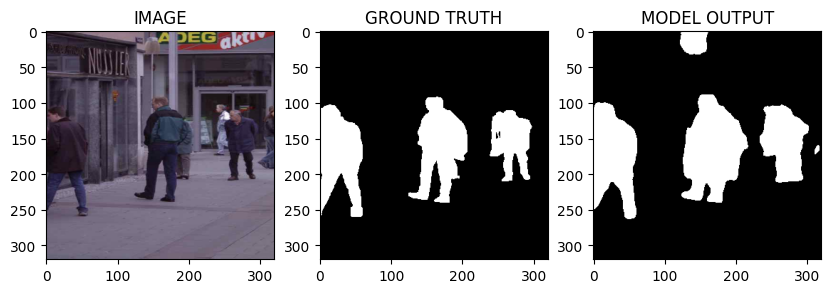

In [37]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))